# MODELO SVM Y TÉCNICAS DE BAGGING

Antes de comenzar con los modelos de clasificación, se han importado las librerías necesarias para todo el código, seguido de la lectura de los conjuntos de entrenamiento y test.

In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Cargar los ficheros de entrenamiento y de test
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Ahora, se han separado los valores (X) de las etiquetas (y) para train y para test. Posteriormente, se han escalado los datos para tratar la gran variabilidad presente en las escalas de los datos y facilitar la convergencia.

In [5]:
#Tomar los datos X_train e y_test
X_train = train.drop(columns=['is_anomaly', 'fold'])
y_train = train['is_anomaly']
X_test = test.drop(columns=['is_anomaly'])
y_test = test['is_anomaly']

#Escalar los datos de entrenamiento y de test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

Posteriormente, se ha implementado la fucnión para separar los datos de entrenamiento en 4 folds para la validación cruzada.

In [7]:
# Función para generar los splits según los folds existentes en el dataset de entrenamiento
def get_cv_iterable(folds, fold_column, train):
    for fold in folds:
        test_indexes = train[train[fold_column] == fold].index
        train_indexes = train[train[fold_column] != fold].index
        yield (train_indexes, test_indexes)

# Obtener los folds únicos
folds = train['fold'].unique()

## Modelo SVM

En primer lugar, se han seleccionado diferentes valores para los hiperparámetros C, gamma y kernel del SVM. Tras esto, se ha entrenado el modelo SVM y se ha evaluado el mejor modelo obtenido con el conjunto de prueba.

In [9]:
# Definir los parámetros para GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],       # Parámetro de penalización
    'gamma': ['scale', 'auto', 0.1], 
    'kernel': ['rbf', 'linear']  # Tipos de kernel
}

# Crear el generador de splits con la función
cv_iterable = get_cv_iterable(folds=folds, fold_column='fold', train=train)

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    scoring='f1',
    cv=cv_iterable, 
    n_jobs=-1, 
    verbose=1
)

# Entrenar el modelo SVM
grid_search.fit(X_train_scaled, y_train)

best_f1 = grid_search.best_score_
print("Mejor F1 Promedio:", best_f1)

# Evaluar el mejor modelo en el conjunto de test
best_model = grid_search.best_estimator_

#Para el conjunto de entrenamiento
y_pred_train = best_model.predict(X_train_scaled)
#Para el conjunto de prueba
y_pred_test = best_model.predict(X_test_scaled)



print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))

cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)
print("\nConfusion Matrix train:\n", cm_train)
print("\nConfusion Matrix test:\n", cm_test)

Fitting 4 folds for each of 18 candidates, totalling 72 fits
Mejor F1 Promedio: 0.9419611683409056
Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

Classification Report:
               precision    recall  f1-score   support

       False       0.99      1.00      1.00      1279
        True       0.98      0.86      0.92        74

    accuracy                           0.99      1353
   macro avg       0.99      0.93      0.96      1353
weighted avg       0.99      0.99      0.99      1353


Confusion Matrix train:
 [[4443    2]
 [   2  215]]

Confusion Matrix test:
 [[1278    1]
 [  10   64]]


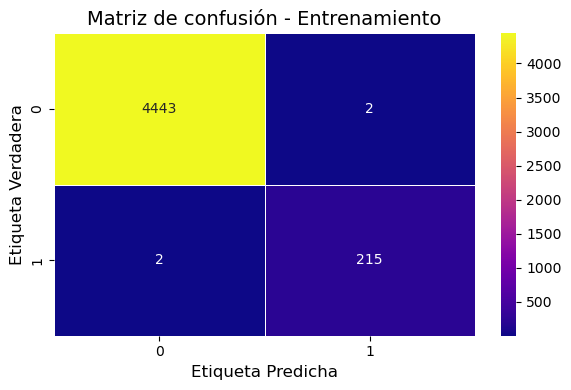

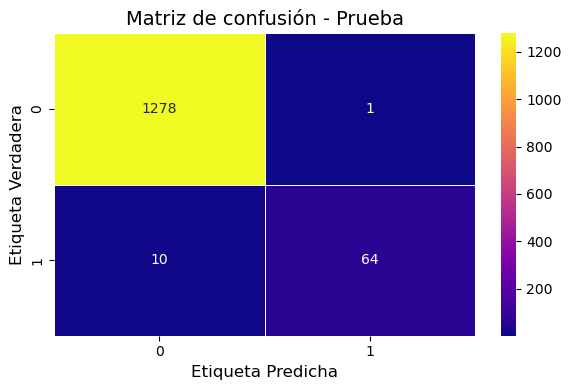

In [11]:
def plot_confusion_matrix(cm, title, filename):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='plasma', cbar=True, linewidths=0.5)
    plt.title(title, fontsize=14)
    plt.ylabel('Etiqueta Verdadera', fontsize=12)
    plt.xlabel('Etiqueta Predicha', fontsize=12)
    plt.tight_layout()  # Ajusta el layout para que no se recorten elementos
    plt.savefig(filename, dpi=300)  # Guarda la imagen con alta calidad (300 dpi)
    plt.show()

# Matriz de confusión para entrenamiento
plot_confusion_matrix(cm_train, "Matriz de confusión - Entrenamiento", "matriz_entrenamiento.png")

# Matriz de confusión para prueba
plot_confusion_matrix(cm_test, "Matriz de confusión - Prueba", "matriz_prueba.png")

## Bagging

Para estas técnicas no se han escalado los datos.

Fitting 4 folds for each of 81 candidates, totalling 324 fits
Mejor F1 Promedio: 0.9385072324011572
Best Parameters (Random Forest): {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Classification Report (Random Forest):
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      1279
        True       0.96      0.95      0.95        74

    accuracy                           0.99      1353
   macro avg       0.98      0.97      0.97      1353
weighted avg       0.99      0.99      0.99      1353


Confusion Matrix train (Random Forest):
 [[4445    0]
 [   1  216]]

Confusion Matrix test (Random Forest):
 [[1276    3]
 [   4   70]]


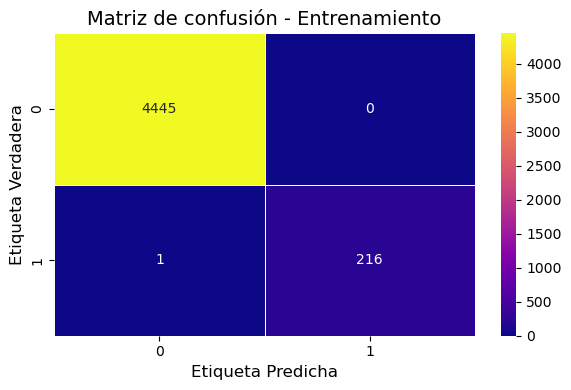

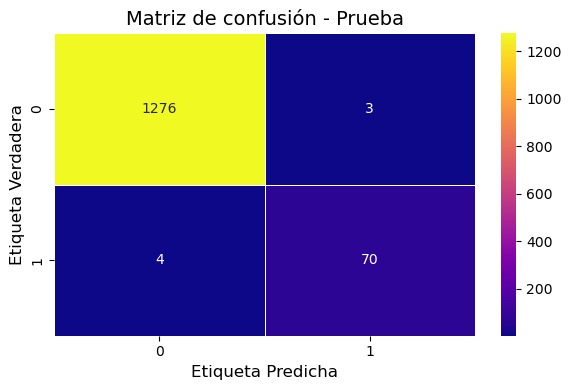

In [13]:
#Código para implementar el Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Número de árboles
    'max_depth': [None, 10, 20],      # Profundidad máxima de cada árbol
    'min_samples_split': [2, 5, 10],  # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4]     # Mínimo de muestras en las hojas
}

cv_iterable = get_cv_iterable(folds=folds, fold_column='fold', train=train)

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='f1',
    cv=cv_iterable,
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)

best_f1_rf = grid_search_rf.best_score_
print("Mejor F1 Promedio:", best_f1_rf)

best_rf_model = grid_search_rf.best_estimator_
y_pred_rf_test = best_rf_model.predict(X_test)

#Para el conjunto de entrenamiento
y_pred_rf_train = best_rf_model.predict(X_train)

print("Best Parameters (Random Forest):", grid_search_rf.best_params_)
print("\nClassification Report (Random Forest):\n", classification_report(y_test, y_pred_rf_test))

cm_train_rf = confusion_matrix(y_train,y_pred_rf_train)
print("\nConfusion Matrix train (Random Forest):\n", cm_train_rf)
cm_test_rf = confusion_matrix(y_test, y_pred_rf_test)
print("\nConfusion Matrix test (Random Forest):\n", cm_test_rf)

# Matriz de confusión para entrenamiento
plot_confusion_matrix(cm_train_rf, "Matriz de confusión - Entrenamiento", "matriz_entrenamiento-rf.png")

# Matriz de confusión para prueba
plot_confusion_matrix(cm_test_rf, "Matriz de confusión - Prueba", "matriz_prueba-rf.png")

Fitting 4 folds for each of 16 candidates, totalling 64 fits
Mejor F1 Promedio: 0.9448753745813503
Best Parameters (ExtraTrees): {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

Classification Report (ExtraTrees):
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      1279
        True       0.97      0.93      0.95        74

    accuracy                           0.99      1353
   macro avg       0.98      0.97      0.97      1353
weighted avg       0.99      0.99      0.99      1353


Confusion Matrix train (ExtraTrees):
 [[4443    2]
 [   5  212]]

Confusion Matrix test (ExtraTrees):
 [[1277    2]
 [   5   69]]


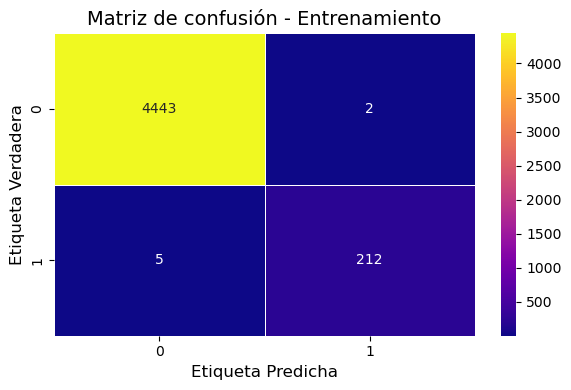

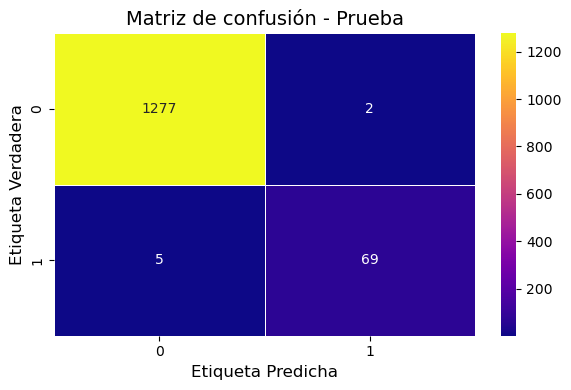

In [15]:
#Códgio para ExtraTrees
param_grid_et = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

cv_iterable = get_cv_iterable(folds=folds, fold_column='fold', train=train)

grid_search_et = GridSearchCV(
    estimator=ExtraTreesClassifier(random_state=42),
    param_grid=param_grid_et,
    scoring='f1',
    cv=cv_iterable,
    n_jobs=-1,
    verbose=1
)

grid_search_et.fit(X_train, y_train)

best_f1_et = grid_search_et.best_score_
print("Mejor F1 Promedio:", best_f1_et)

best_et_model = grid_search_et.best_estimator_
y_pred_et_test = best_et_model.predict(X_test)

#Para el conjunto de entrenamiento
y_pred_et_train = best_et_model.predict(X_train)

print("Best Parameters (ExtraTrees):", grid_search_et.best_params_)
print("\nClassification Report (ExtraTrees):\n", classification_report(y_test, y_pred_et_test))

cm_train_et = confusion_matrix(y_train, y_pred_et_train)
cm_test_et = confusion_matrix(y_test, y_pred_et_test)
print("\nConfusion Matrix train (ExtraTrees):\n", cm_train_et)
print("\nConfusion Matrix test (ExtraTrees):\n", cm_test_et)

# Matriz de confusión para entrenamiento
plot_confusion_matrix(cm_train_et, "Matriz de confusión - Entrenamiento", "matriz_entrenamiento-et.png")

# Matriz de confusión para prueba
plot_confusion_matrix(cm_test_et, "Matriz de confusión - Prueba", "matriz_prueba-et.png")

Fitting 4 folds for each of 27 candidates, totalling 108 fits
Mejor F1 Promedio: 0.9325096314415411
Best Parameters (Random Subspaces): {'estimator__max_depth': None, 'max_features': 0.75, 'n_estimators': 50}

Classification Report (Random Subspaces):
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      1279
        True       0.96      0.93      0.95        74

    accuracy                           0.99      1353
   macro avg       0.98      0.97      0.97      1353
weighted avg       0.99      0.99      0.99      1353


Confusion Matrix train (Random Subspaces):
 [[4445    0]
 [   0  217]]

Confusion Matrix test (Random Subspaces):
 [[1276    3]
 [   5   69]]


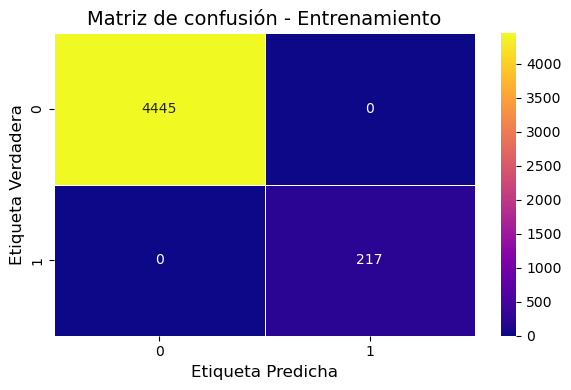

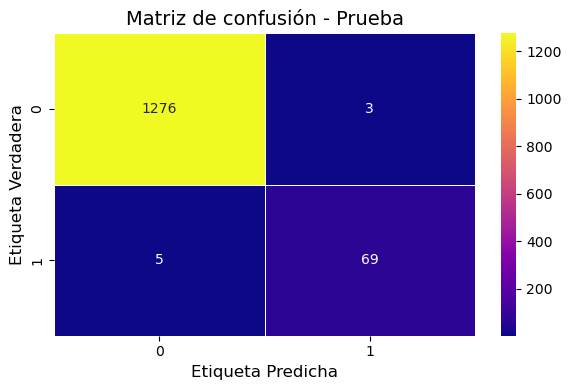

In [17]:
#Código para el Random Subspaces
param_grid_rs = {
    'n_estimators': [50, 100, 150], 
    'max_features': [0.5, 0.75, 1.0], 
    'estimator__max_depth': [None, 10, 20]  
}

cv_iterable = get_cv_iterable(folds=folds, fold_column='fold', train=train)

grid_search_rs = GridSearchCV(
    estimator=BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42),
    param_grid=param_grid_rs,
    scoring='f1',
    cv=cv_iterable,
    n_jobs=-1,
    verbose=1
)

grid_search_rs.fit(X_train, y_train)

best_f1_rs = grid_search_rs.best_score_
print("Mejor F1 Promedio:", best_f1_rs)

best_rs_model = grid_search_rs.best_estimator_
y_pred_rs_test = best_rs_model.predict(X_test)

#Para el conjunto de entrenamiento
y_pred_rs_train = best_rs_model.predict(X_train)

print("Best Parameters (Random Subspaces):", grid_search_rs.best_params_)
print("\nClassification Report (Random Subspaces):\n", classification_report(y_test, y_pred_rs_test))

cm_train_rs = confusion_matrix(y_train, y_pred_rs_train)
cm_test_rs = confusion_matrix(y_test, y_pred_rs_test)
print("\nConfusion Matrix train (Random Subspaces):\n", cm_train_rs)
print("\nConfusion Matrix test (Random Subspaces):\n", cm_test_rs)

# Matriz de confusión para entrenamiento
plot_confusion_matrix(cm_train_rs, "Matriz de confusión - Entrenamiento", "matriz_entrenamiento-rs.png")

# Matriz de confusión para prueba
plot_confusion_matrix(cm_test_rs, "Matriz de confusión - Prueba", "matriz_prueba-rs.png")